In [1]:
import pandas as pd
import numpy as np
import os
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta, date
import operator

from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import KFold
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

C:\Users\Kohei\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data_path = 'C:/Users/Kohei/Documents/Kaggle/Recruit/02_data/02_17b/'
path = 'C:/Users/Kohei/Documents/Kaggle/Recruit/03_xgb/03_17bb/'
ver = '03_17bb_xgb'

In [3]:
ID = ['air_store_id','visit_date','flag']
TARGET='visitors'

In [4]:
def RMSLE(y, pred):
    return mean_squared_error(y, pred) ** 0.5

In [5]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

In [40]:
def model_run(df):
    train = pd.read_csv(os.path.join(data_path, df+'.csv'))
    test = pd.read_csv(os.path.join(data_path, 'test_all.csv'))
    if df=='train1':
        test = test.loc[test.flag==1,:].reset_index(drop=True)
    elif df=='train2':
        test = test.loc[test.flag==2,:].reset_index(drop=True)
        
    y_train = np.log1p(train['visitors'])
    id_train = train[ID]
    id_test  = test[ID]
    x_train = train
    x_test = test
    x_train.drop(ID, axis=1, inplace=True)
    x_train.drop(TARGET, axis=1, inplace=True)
    x_test.drop(ID, axis=1, inplace=True)
    del train, test
    
    drop_cols = ['var_max_lat','var_max_long','km_hpg_latlong']
    x_train.drop(drop_cols,axis=1, inplace=True)
    x_test.drop(drop_cols,axis=1, inplace=True)

    x_train['genre_mean+areaL3_mean'] = x_train['genre_mean']+x_train['areaL3_mean'] 
    x_test['genre_mean+areaL3_mean']  = x_test['genre_mean']+x_test['areaL3_mean'] 

    x_train['wind_max_x_rainfall'] = x_train['wind_max']*x_train['rainfall'] 
    x_test['wind_max_x_rainfall']  = x_test['wind_max']*x_test['rainfall'] 
        
    n_folds = 5
    bagging = 1
    divisor = 1
    cv_sum = 0
    pred_tr_all = []
    pred_te_all = []

    kf = KFold(x_train.shape[0], n_folds=n_folds, random_state=1234, shuffle=True)

    nrounds = 80000
    verbose_eval = 1000
    early_stopping_rounds = 100

    d_test = xgb.DMatrix(x_test)

    for i, (tr_index,vl_index) in enumerate(kf):
        print('\nFold %d / %d' % (i+1, n_folds))
        pred = []
        pred_vl = []

        x_tr, x_vl = x_train.loc[tr_index].copy(), x_train.loc[vl_index].copy()
        y_tr, y_vl = y_train[tr_index], y_train[vl_index]
        id_vl      = id_train.loc[vl_index].copy()
        
        for j in range(1,bagging+1):
            print('\nBagging %d / %d' % (j, bagging))

            # sampling
#             np.random.seed(j)
#             sample = np.random.choice(len(x_tr), size=int(len(x_tr)/divisor))
#             x_tr_bag = x_tr.iloc[sample]
#             y_tr_bag = y_tr.iloc[sample]
            x_tr_bag = x_tr
            y_tr_bag = y_tr

            d_train = xgb.DMatrix(x_tr_bag, label=y_tr_bag)
            d_valid = xgb.DMatrix(x_vl, label=y_vl)
            watchlist = [(d_train,'train'),(d_valid,'valid')]

            params = {'seed': (j-1),
                      'subsample': 0.80,
                      'colsample_bytree': 0.70,
                      'silent': 1,
                      'learning_rate': 0.01,
                      'objective': 'reg:linear',
                      'max_depth': 10,
                      'min_child_weight': 20,
                      'alpha': 0, # default=0
                      'lambda': 20,# default=1
                      'gamma': 0.01, # default=0
                      'booster': 'gbtree'}

            clf = xgb.train(params,
                            d_train,
                            nrounds,
                            watchlist,
                            verbose_eval=verbose_eval,
                            early_stopping_rounds = early_stopping_rounds)
            if j==1:
                pred_v = clf.predict(d_valid, ntree_limit=clf.best_ntree_limit)
                pred_t = clf.predict(d_test, ntree_limit=clf.best_ntree_limit)
            else:
                pred_v += clf.predict(d_valid, ntree_limit=clf.best_ntree_limit)    
                pred_t += clf.predict(d_test, ntree_limit=clf.best_ntree_limit)    
            pred_vl = (pred_v/j)
            pred_te = (pred_t/j)

            cv_score = RMSLE(y_vl, pred_vl)
            print('Fold RMSLE : %.6f' % cv_score)

        # end of bagging
        pred = id_vl
        pred['pred'] = pred_vl

        if i==0:
            pred_tr_all = pred
            pred_te_all = pred_te
        else:
            pred_tr_all = pd.concat([pred_tr_all,pred])
            pred_te_all += pred_te

        cv_sum = cv_sum + cv_score

    pred_te_all /= n_folds
    pred_te_all = pd.DataFrame({'pred':pred_te_all})
    pred_te_all = pd.concat([id_test,pred_te_all],axis=1)

    print('CV RMSLE : %.6f' % (cv_sum / n_folds))
    
    # variable importance
    feature_names = x_train.columns
    create_feature_map(feature_names)
    importance = clf.get_fscore(fmap='xgb.fmap')
    importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)
    varimp = pd.DataFrame(importance, columns=['feature', 'fscore'])
    varimp.to_csv(path+'/'+ver+'_varimp_'+df+'.csv', index=False)

    return pred_tr_all, pred_te_all

In [45]:
pred_tr, pred_te = model_run('train_all')
pred_tr.to_csv(path+'/'+ver+'_pred_tr.csv', index=False)
pred_te.to_csv(path+'/'+ver+'_pred_te.csv', index=False)


Fold 1 / 5

Bagging 1 / 1
[0]	train-rmse:2.40932	valid-rmse:2.41322
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[1000]	train-rmse:0.467857	valid-rmse:0.51102
[2000]	train-rmse:0.430916	valid-rmse:0.506437
[3000]	train-rmse:0.400234	valid-rmse:0.504839
[4000]	train-rmse:0.371482	valid-rmse:0.504148
Stopping. Best iteration:
[4036]	train-rmse:0.370388	valid-rmse:0.504134

Fold RMSLE : 0.504134

Fold 2 / 5

Bagging 1 / 1
[0]	train-rmse:2.41038	valid-rmse:2.40895
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[1000]	train-rmse:0.467818	valid-rmse:0.51261
[2000]	train-rmse:0.43157	valid-rmse:0.507724
[3000]	train-rmse:0.400292	valid-rmse:0.505958
[4000]	train-rmse:0.371771	valid-rmse:0.505273
Stopping. Best iteration:
[4221]	train-rmse:0.365706	valid-rmse:0.505207

Fold RMSLE : 0.505207

Fold

In [41]:
pred_tr1, pred_te1 = model_run('train1')
pred_tr1.to_csv(path+'/'+ver+'_pred_tr1.csv', index=False)
pred_te1.to_csv(path+'/'+ver+'_pred_te1.csv', index=False)


Fold 1 / 5

Bagging 1 / 1
[0]	train-rmse:2.41269	valid-rmse:2.40918
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[1000]	train-rmse:0.448557	valid-rmse:0.500997
[2000]	train-rmse:0.410886	valid-rmse:0.499182
[3000]	train-rmse:0.378465	valid-rmse:0.498604
Stopping. Best iteration:
[3171]	train-rmse:0.372961	valid-rmse:0.498541

Fold RMSLE : 0.498541

Fold 2 / 5

Bagging 1 / 1
[0]	train-rmse:2.4122	valid-rmse:2.41114
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[1000]	train-rmse:0.447841	valid-rmse:0.501907
[2000]	train-rmse:0.410577	valid-rmse:0.499719
[3000]	train-rmse:0.377078	valid-rmse:0.499041
Stopping. Best iteration:
[3275]	train-rmse:0.368656	valid-rmse:0.49893

Fold RMSLE : 0.498930

Fold 3 / 5

Bagging 1 / 1
[0]	train-rmse:2.41139	valid-rmse:2.41436
Multiple eval metrics have be

In [42]:
pred_tr2, pred_te2 = model_run('train2')
pred_tr2.to_csv(path+'/'+ver+'_pred_tr2.csv', index=False)
pred_te2.to_csv(path+'/'+ver+'_pred_te2.csv', index=False)


Fold 1 / 5

Bagging 1 / 1
[0]	train-rmse:2.40927	valid-rmse:2.41158
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[1000]	train-rmse:0.472082	valid-rmse:0.520948
[2000]	train-rmse:0.435899	valid-rmse:0.516414
[3000]	train-rmse:0.404468	valid-rmse:0.514821
[4000]	train-rmse:0.375161	valid-rmse:0.514266
Stopping. Best iteration:
[4054]	train-rmse:0.37373	valid-rmse:0.514239

Fold RMSLE : 0.514239

Fold 2 / 5

Bagging 1 / 1
[0]	train-rmse:2.40886	valid-rmse:2.41329
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[1000]	train-rmse:0.473585	valid-rmse:0.516899
[2000]	train-rmse:0.436382	valid-rmse:0.512564
[3000]	train-rmse:0.405653	valid-rmse:0.510928
[4000]	train-rmse:0.37672	valid-rmse:0.510329
Stopping. Best iteration:
[4260]	train-rmse:0.369405	valid-rmse:0.510263

Fold RMSLE : 0.510263

Fol

In [43]:
sub = pd.read_csv('C:/Users/Kohei/Documents/Kaggle/Recruit/00_input/sample_submission.csv')
sub['air_store_id'] = sub.id.map(lambda x: '_'.join(x.split('_')[:-1]))
sub['visit_date']   = sub.id.map(lambda x: x.split('_')[2])
sub['visit_date'] = pd.to_datetime(sub['visit_date'])

pred_te = pd.concat([pred_te1,pred_te2])
pred_te['visit_date'] = pd.to_datetime(pred_te['visit_date'])

# submission
sub.loc[:,'visitors'] = sub.merge(pred_te, on=['air_store_id','visit_date'], how='left')['pred'].values
sub['visitors'] = np.expm1(sub['visitors'])
sub_file = path+'/'+ver+'_sub.csv'
sub[['id','visitors']].to_csv(sub_file, index=False)

# adjusted subumission
sub['pred'] = sub['visitors']
sub.loc[sub.visit_date==date(2017,4,25),'visitors']*=1.10 # Tuesday-judgmental

sub.loc[sub.visit_date==date(2017,4,27),'visitors']*=1.10 # Thursday-judgmental

sub.loc[sub.visit_date==date(2017,4,30),'visitors']*=1.35 # Sunday-judgmental-
sub.loc[sub.visit_date==date(2017,5,1),'visitors'] *=1.20 # Monday-judgmental-should be high because in-between
sub.loc[sub.visit_date==date(2017,5,2),'visitors'] *=1.10 # Tuesday-judgmental-should be high because in-between
sub.loc[sub.visit_date==date(2017,5,3),'visitors'] *=1.10 # Day1
sub.loc[sub.visit_date==date(2017,5,4),'visitors'] *=1.10 # Day2
sub.loc[sub.visit_date==date(2017,5,5),'visitors'] *=1.05 # Day3
sub.loc[sub.visit_date==date(2017,5,6),'visitors'] *=1.00 # Saturday
sub.loc[sub.visit_date==date(2017,5,7),'visitors'] *=0.95 # Sunday
sub.loc[sub.visit_date==date(2017,5,8),'visitors'] *=0.90 # Monday
sub.loc[sub.visit_date==date(2017,5,9),'visitors'] *=0.90 # Tuesday
sub_file = path+'/'+ver+'_sub_adjusted.csv'
sub[['id','visitors']].to_csv(sub_file, index=False)

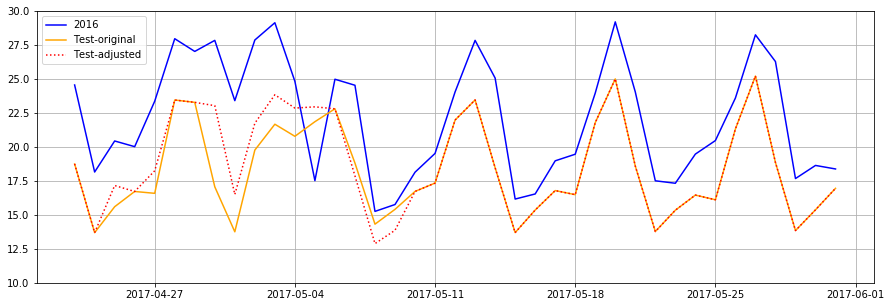

In [44]:
# 2016 Act vs 2017 Pred
pred = pd.DataFrame(sub.groupby(['visit_date'])['pred','visitors'].mean().reset_index()).rename(columns={'visitors':'pred_adj'})

train = pd.read_csv('C:/Users/Kohei/Documents/Kaggle/Recruit/00_input/air_visit_data.csv')[['visit_date','visitors']]
train['visit_date'] = pd.to_datetime(train['visit_date'])
train['visit_date'] = train['visit_date']+timedelta(days=365-1)
df = train[train.visit_date>=date(2017,4,23)]
df = df[df.visit_date<=date(2017,5,31)]
df = pd.DataFrame(df.groupby(['visit_date'])['visitors'].mean().reset_index())

df = df.merge(pred, on='visit_date', how='left')

fig = plt.figure(figsize=(15,5))
plt.plot(df.visit_date, df.visitors, "blue", label = "2016")
plt.plot(df.visit_date, df.pred, "orange", label = "Test-original")
plt.plot(df.visit_date, df.pred_adj, "red", label = "Test-adjusted", linestyle='dotted')
plt.ylim(10,30)
plt.legend(loc='upper left')
plt.grid()